In [1]:
import numpy as np
import os,math,random
from matplotlib import pyplot as plt
from scipy.stats import binned_statistic, binned_statistic_2d
from astropy.table import Table, vstack
from astropy.cosmology import FlatLambdaCDM, z_at_value
from astropy import units as u
from astropy.constants import k_B, m_p, G, M_sun
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from gdpyc import GasMap, DustMap
import time
import pandas as pd
from scipy.interpolate import interp2d, interp1d
from scipy import interpolate

/Users/zhengyunliang/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
cosmo = FlatLambdaCDM(Om0=0.315,H0=100)

In [3]:
def isLRG_colors(gflux=None, rflux=None, zflux=None, w1flux=None,
                 zfiberflux=None, ggood=None,
                 w2flux=None, primary=None, south=True):
    if primary is None:
        primary = np.ones_like(rflux, dtype='?')
    lrg = primary.copy()
    # ADM to maintain backwards-compatibility with mocks.
    if zfiberflux is None:
        log.warning('Setting zfiberflux to zflux!!!')
        zfiberflux = zflux.copy()
    gmag = 22.5 - 2.5 * np.log10(gflux.clip(1e-7))
    # ADM safe as these fluxes are set to > 0 in notinLRG_mask.
    rmag = 22.5 - 2.5 * np.log10(rflux.clip(1e-7))
    zmag = 22.5 - 2.5 * np.log10(zflux.clip(1e-7))
    w1mag = 22.5 - 2.5 * np.log10(w1flux.clip(1e-7))
    zfibermag = 22.5 - 2.5 * np.log10(zfiberflux.clip(1e-7))
    # Full SV3 selection
    if south:
        lrg &= zmag - w1mag > 0.8 * (rmag - zmag) - 0.6  # non-stellar cut
        lrg &= zfibermag < 21.6                   # faint limit
        lrg &= (gmag - w1mag > 2.9) | (rmag - w1mag > 1.8)  # low-z cuts
        lrg &= (
            ((rmag - w1mag > (w1mag - 17.14) * 1.8)
             & (rmag - w1mag > (w1mag - 16.33) * 1.))
            | (rmag - w1mag > 3.3)
        )  # double sliding cuts and high-z extension
    else:
        lrg &= zmag - w1mag > 0.8 * (rmag - zmag) - 0.6  # non-stellar cut
        lrg &= zfibermag < 21.61                   # faint limit
        lrg &= (gmag - w1mag > 2.97) | (rmag - w1mag > 1.8)  # low-z cuts
        lrg &= (
            ((rmag - w1mag > (w1mag - 17.13) * 1.83)
             & (rmag - w1mag > (w1mag - 16.31) * 1.))
            | (rmag - w1mag > 3.4)
        )  # double sliding cuts and high-z extension
    return lrg

def isELG_colors(gflux=None, rflux=None, zflux=None, w1flux=None,
                 w2flux=None, gfiberflux=None, south=True, primary=None):
    if primary is None:
        primary = np.ones_like(rflux, dtype='?')
    elg = primary.copy()
    # ADM work in magnitudes instead of fluxes. NOTE THIS IS ONLY OK AS
    # ADM the snr masking in ALL OF g, r AND z ENSURES positive fluxes.
    g = 22.5 - 2.5*np.log10(gflux.clip(1e-16))
    r = 22.5 - 2.5*np.log10(rflux.clip(1e-16))
    z = 22.5 - 2.5*np.log10(zflux.clip(1e-16))
    gfib = 22.5 - 2.5*np.log10(gfiberflux.clip(1e-16))
    # ADM cuts shared by the northern and southern selections.
    elg &= g > 20                       # bright cut.
    elg &= r - z > 0.15                  # blue cut.
#    elg &= r - z < 1.6                  # red cut.
    # ADM cuts that are unique to the north or south. Identical for sv3
    # ADM but keep the north/south formalism in case we use it later.
    if south:
        elg &= gfib < 24.1  # faint cut.
        elg &= g - r < 0.5*(r - z) + 0.1  # remove stars, low-z galaxies.
    else:
        elg &= gfib < 24.1  # faint cut.
        elg &= g - r < 0.5*(r - z) + 0.1  # remove stars, low-z galaxies.
    # ADM separate a low-priority and a regular sample.
    elgvlo = elg.copy()
    # ADM low-priority OII flux cut.
    elgvlo &= g - r < -1.2*(r - z) + 1.6
    elgvlo &= g - r >= -1.2*(r - z) + 1.3
    # ADM high-priority OII flux cut.
    elg &= g - r < -1.2*(r - z) + 1.3
    return elgvlo, elg

In [4]:
Cens = Table.read('../data/DESI/CensACT.fits')
Cens['R180'] = (((10**Cens['logMh']*M_sun)/(4*np.pi/3*180*cosmo.Om(0)*3*(cosmo.H0**2)/(8*np.pi*G)))**(1./3)).to('kpc')/(1+Cens['z'])
Cens['R180_ang'] = Cens['R180']/cosmo.angular_diameter_distance(Cens['z']).to('kpc')

bcg_pos = SkyCoord(Cens['ra']*u.deg, Cens['dec']*u.deg)
xry_pos = SkyCoord(Cens['RA_X']*u.deg, Cens['DEC_X']*u.deg)
luw_pos = SkyCoord(Cens['ragroup']*u.deg, Cens['decgroup']*u.deg)

In [5]:
Cens['nH'] = GasMap.nh(luw_pos, nhmap='DL').to('1/cm2').value

In [6]:
Sats = Table.read('../data/DESI/SatsLite.fits')

In [7]:
# BPT
sn_thre_ = 2
Cens['is_BPT'] = np.zeros(len(Cens))-99
sel_thre_s = (Cens['SN_NII']>=sn_thre_)&(Cens['SN_HA']>=sn_thre_)&(Cens['SN_OIII']>=sn_thre_)&(Cens['SN_HB']>=sn_thre_)
sel_thre_w = (Cens['SN_NII']>=sn_thre_)&(Cens['SN_HA']>=sn_thre_)&((Cens['SN_OIII']<sn_thre_)|(Cens['SN_HB']<sn_thre_))
Cens['is_BPT'][(sel_thre_s|sel_thre_w)] = 1
sel_CN_a_ = (Cens['BPTOIII']>0.61/(Cens['BPTNII']-0.47)+1.19)|(Cens['BPTNII']>=0.47)
sel_CN_w_ = (Cens['EWHA']>np.log10(3))&(Cens['BPTNII']>-0.1)
Cens['is_BPT'][(sel_thre_s&sel_CN_a_)|(sel_thre_w&sel_CN_w_)] = 2
sel_CN_as = (Cens['BPTOIII']<0.61/(Cens['BPTNII']-0.05)+1.3)&(Cens['BPTNII']<0.05)
sel_CN_ws = (Cens['SN_NII']>sn_thre_)&(Cens['SN_HA']>sn_thre_)&((Cens['SN_OIII']<=sn_thre_)|(Cens['SN_HB']<=sn_thre_))&((Cens['BPTNII']<-0.32)|(Cens['EWHA']<np.log10(3)))
Cens['is_BPT'][(sel_thre_s&sel_CN_as)|(sel_thre_w&sel_CN_ws)] = 0

Sats['is_BPT'] = np.zeros(len(Sats))-99
sel_thre_s = (Sats['SN_NII']>=sn_thre_)&(Sats['SN_HA']>=sn_thre_)&(Sats['SN_OIII']>=sn_thre_)&(Sats['SN_HB']>=sn_thre_)
sel_thre_w = (Sats['SN_NII']>=sn_thre_)&(Sats['SN_HA']>=sn_thre_)&((Sats['SN_OIII']<sn_thre_)|(Sats['SN_HB']<sn_thre_))
Sats['is_BPT'][(sel_thre_s|sel_thre_w)] = 1
sel_CN_a_ = (Sats['BPTOIII']>0.61/(Sats['BPTNII']-0.47)+1.19)|(Sats['BPTNII']>=0.47)
sel_CN_w_ = (Sats['EWHA']>np.log10(3))&(Sats['BPTNII']>-0.1)
Sats['is_BPT'][(sel_thre_s&sel_CN_a_)|(sel_thre_w&sel_CN_w_)] = 2
sel_CN_as = (Sats['BPTOIII']<0.61/(Sats['BPTNII']-0.05)+1.3)&(Sats['BPTNII']<0.05)
sel_CN_ws = (Sats['SN_NII']>sn_thre_)&(Sats['SN_HA']>sn_thre_)&((Sats['SN_OIII']<=sn_thre_)|(Sats['SN_HB']<=sn_thre_))&((Sats['BPTNII']<-0.32)|(Sats['EWHA']<np.log10(3)))
Sats['is_BPT'][(sel_thre_s&sel_CN_as)|(sel_thre_w&sel_CN_ws)] = 0

In [8]:
Cens['seq'] = np.zeros((len(Cens),2)).astype('int')
xx_ = (Cens['ra']!=Cens['RA_X'])
Cens['seq'][:,0][xx_] = 1
Cens['seq'][:,1][~(xx_)] = 1

In [9]:
gflux=Sats['FLUX_G']/Sats['MW_TRANSMISSION_G']
rflux=Sats['FLUX_R']/Sats['MW_TRANSMISSION_R']
zflux=Sats['FLUX_Z']/Sats['MW_TRANSMISSION_Z']
w1flux=Sats['FLUX_W1']/Sats['MW_TRANSMISSION_W1']
w2flux=Sats['FLUX_W2']/Sats['MW_TRANSMISSION_W2']
gfiberflux=Sats['FIBERFLUX_G']/Sats['MW_TRANSMISSION_G']
rfiberflux=Sats['FIBERFLUX_R']/Sats['MW_TRANSMISSION_R']
zfiberflux=Sats['FIBERFLUX_Z']/Sats['MW_TRANSMISSION_Z']
rfibertotflux=Sats['FIBERTOTFLUX_R']/Sats['MW_TRANSMISSION_R']

/var/folders/8k/p6qnzbn934jd2z75vwrs1j2h0000gn/T/ipykernel_27426/2621183821.py:1: RuntimeWarning: invalid value encountered in divide
  gflux=Sats['FLUX_G']/Sats['MW_TRANSMISSION_G']
/var/folders/8k/p6qnzbn934jd2z75vwrs1j2h0000gn/T/ipykernel_27426/2621183821.py:2: RuntimeWarning: invalid value encountered in divide
  rflux=Sats['FLUX_R']/Sats['MW_TRANSMISSION_R']
/var/folders/8k/p6qnzbn934jd2z75vwrs1j2h0000gn/T/ipykernel_27426/2621183821.py:3: RuntimeWarning: invalid value encountered in divide
  zflux=Sats['FLUX_Z']/Sats['MW_TRANSMISSION_Z']
/var/folders/8k/p6qnzbn934jd2z75vwrs1j2h0000gn/T/ipykernel_27426/2621183821.py:4: RuntimeWarning: invalid value encountered in divide
  w1flux=Sats['FLUX_W1']/Sats['MW_TRANSMISSION_W1']
/var/folders/8k/p6qnzbn934jd2z75vwrs1j2h0000gn/T/ipykernel_27426/2621183821.py:5: RuntimeWarning: invalid value encountered in divide
  w2flux=Sats['FLUX_W2']/Sats['MW_TRANSMISSION_W2']
/var/folders/8k/p6qnzbn934jd2z75vwrs1j2h0000gn/T/ipykernel_27426/2621183821.py:

In [10]:
elglo_iron, elg_iron = isELG_colors(gflux=gflux, rflux=rflux, zflux=zflux, w1flux=w1flux, w2flux=w2flux, gfiberflux=gfiberflux, south=True, primary=None)
lrg_iron = isLRG_colors(gflux=gflux, rflux=rflux, zflux=zflux, w1flux=w1flux, zfiberflux=zfiberflux, ggood=None, w2flux=w2flux, primary=None, south=True)

Sats['ELG'] = (elglo_iron|elg_iron)
Sats['LRG'] = lrg_iron
radio_sat = (Sats['ASKAP_idx']>0)
qso_sat = (Sats['is_QSO']==1)
bpt_sat = (Sats['is_BPT']>=1)
Sats = Sats[(Sats['ELG']==1)|(Sats['LRG']==1)|radio_sat|qso_sat|bpt_sat]

In [11]:
def create_circular_mask(h, w, center=None, radius=None):
    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])
    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y - center[1])**2)
    mask = dist_from_center <= radius
    return mask

## $2 \times 2$ bins in $M_h$ and Redshift Spaces

In [12]:
step = 0.5
mbins = np.arange(14,15.1,step)
layers = 2

r180_min = np.zeros((2,len(mbins)-1))
r180_med = np.zeros((2,len(mbins)-1))
r180_max = np.zeros((2,len(mbins)-1))
r180_min_ang = np.zeros((2,len(mbins)-1))
r180_med_ang = np.zeros((2,len(mbins)-1))
r180_max_ang = np.zeros((2,len(mbins)-1))

for zz in range(2):
    for mm in range(len(mbins)-1):
        r180_min[zz,mm] = (((10**mbins[mm]*M_sun)/(4*np.pi/3*180*cosmo.Om(0)*3*cosmo.H0**2/(8*np.pi*G)))**(1./3)).to('kpc').value/(1+0.5*(zz+1))
        r180_med[zz,mm] = (((10**((mbins[mm]+mbins[mm+1])/2)*M_sun)/(4*np.pi/3*180*cosmo.Om(0)*3*cosmo.H0**2/(8*np.pi*G)))**(1./3)).to('kpc').value/(1+0.5*(zz+0.5))
        r180_max[zz,mm] = (((10**(mbins[mm+1])*M_sun)/(4*np.pi/3*180*cosmo.Om(0)*3*cosmo.H0**2/(8*np.pi*G)))**(1./3)).to('kpc').value/(1+0.5*zz)
        r180_min_ang[zz,mm] = r180_min[zz,mm]/cosmo.angular_diameter_distance(0.25+0.5*zz).to('kpc').value
        r180_med_ang[zz,mm] = r180_med[zz,mm]/cosmo.angular_diameter_distance(0.25+0.5*zz).to('kpc').value
        r180_max_ang[zz,mm] = r180_max[zz,mm]/cosmo.angular_diameter_distance(0.25+0.5*zz).to('kpc').value

## eROSITA Tiles Info

In [13]:
tiles = fits.open('../data/eROSITA/SKYMAPS_052022_MPE.fits')
tlt_select = Table(tiles[1].data)
# l_ = elt.transform_to('galactic').l.to('deg').value
elt_sel = SkyCoord(tlt_select['RA_CEN']*u.deg,tlt_select['DE_CEN']*u.deg)

Emin, Emax = 0.5, 2
zoom, zoom2 = 0.5, 4
# idx_srv, d2d_srv, d3d_srv = xry_pos.match_to_catalog_sky(elt_sel)
# srv_n = [i for i in set(tlt_select['SRVMAP'][idx_srv])]

In [14]:
Cens['svmapx'] = np.zeros(len(Cens)).astype('i4')
for kk in range(-69,43,3):
    sel_ = (Cens['DEC_X']>kk-1.5)&(Cens['DEC_X']<=kk+1.5)
    els_ = (tlt_select['DE_CEN']>kk-1.5)&(tlt_select['DE_CEN']<=kk+1.5)
    idx_srv, d2d_srv, d3d_srv = xry_pos[sel_].match_to_catalog_sky(elt_sel[els_])
    Cens['svmapx'][sel_] = tlt_select['SRVMAP'][els_][idx_srv]

In [15]:
Cens['svmapb'] = np.zeros(len(Cens)).astype('i4')
for kk in range(-69,43,3):
    sel_ = (Cens['dec']>kk-1.5)&(Cens['dec']<=kk+1.5)
    els_ = (tlt_select['DE_CEN']>kk-1.5)&(tlt_select['DE_CEN']<=kk+1.5)
    idx_srv, d2d_srv, d3d_srv = bcg_pos[sel_].match_to_catalog_sky(elt_sel[els_])
    Cens['svmapb'][sel_] = tlt_select['SRVMAP'][els_][idx_srv]

In [16]:
Cens['svmapw'] = np.zeros(len(Cens)).astype('i4')
for kk in range(-69,43,3):
    sel_ = (Cens['decgroup']>kk-1.5)&(Cens['decgroup']<=kk+1.5)
    els_ = (tlt_select['DE_CEN']>kk-1.5)&(tlt_select['DE_CEN']<=kk+1.5)
    idx_srv, d2d_srv, d3d_srv = bcg_pos[sel_].match_to_catalog_sky(elt_sel[els_])
    Cens['svmapw'][sel_] = tlt_select['SRVMAP'][els_][idx_srv]

## CTP Catalog

In [17]:
mains = Table.read('../data/eROSITA/catalogs/eRASS1_ctp.fits')
mains.sort('GR')
mainst = SkyCoord(mains['RA'].data*u.deg, mains['DEC'].data*u.deg)

In [18]:
mains['Rsrc'] = (10.754*np.log10(mains['ML_CTS_1'])**2 - 8.989*np.log10(mains['ML_CTS_1']) + 24.49)*1.4
mains['Rsrc'][mains['EXT']>0] = (15.948*np.log10(mains['ML_CTS_1'][mains['EXT']>0])**2 + 0.046*np.log10(mains['ML_CTS_1'][mains['EXT']>0]) + 34.124)*1.2

In [19]:
def tlnm_name(tlnm_):
    if len(tlnm_) == 5:
        tlnm_ = '0'+tlnm_
    elif len(tlnm_) == 4:
        tlnm_ = '00'+tlnm_
    elif len(tlnm_) == 3:
        tlnm_ = '000'+tlnm_
    return tlnm_

def rescale_(mskk, ima_size):
    f_mc = interpolate.interp2d(np.arange(mskk.shape[1]), np.arange(mskk.shape[0]), mskk, kind='linear')
    mskk_rebin = f_mc(np.linspace(0, mskk.shape[1], ima_size), np.linspace(0, mskk.shape[1], ima_size))
    mskk_rebin[mskk_rebin>=0.5] = 1
    mskk_rebin[mskk_rebin<0.5] = 0
    return mskk_rebin

def mask_conta(tabs,detmsk,xx,yy,R_ang,xxs,yys,rrs):
    msk_id = np.ones(len(tabs))
    if len(rrs) > 0:
        mask_sources = []
        for s in range(len(rrs)):
            mask_sj = create_circular_mask(detmsk.shape[0], detmsk.shape[1], 
                                           center=((xxs[s]-xx+R_ang*2), (yys[s]-yy+R_ang*2)),
                                           radius=(rrs[s]/4+30/4))
            mask_sources.append(mask_sj)
            msk_id[np.sqrt((tabs['xx']-xxs[s])**2+(tabs['yy']-yys[s])**2)<(rrs[s]/4+30/4)] = 0
        mask_contamination = 1 - np.sum(np.array(mask_sources), axis=0)
        mask_contamination[mask_contamination < 1] = 0
    else:
        mask_contamination = np.ones((detmsk.shape[0], detmsk.shape[1]))
    return msk_id, mask_contamination

In [20]:
rmf = fits.open('../data/eROSITA/ecfModels/RMF')
rmfE = Table(rmf[2].data)
rmfinfo = Table(rmf[1].data)
ee_rmf = 0.5*(rmfE['E_MIN']+rmfE['E_MAX'])
rmf_matrix = np.zeros((1024, 1024))

# Image Stacking (luminosity-weighted Center)

In [21]:
repeat_ = 51

pure_count = [[[[[]for i in range(2)] for i in range(2)] for i in range(layers)] for i in range(repeat_)]
weighted_count = [[[[[]for i in range(2)] for i in range(2)] for i in range(layers)] for i in range(repeat_)]
mask_ima = [[[[[]for i in range(2)] for i in range(2)] for i in range(layers)] for i in range(repeat_)]

pure_count_sat = [[[[[]for i in range(2)] for i in range(2)] for i in range(layers)] for i in range(repeat_)]
weighted_count_sat = [[[[[]for i in range(2)] for i in range(2)] for i in range(layers)] for i in range(repeat_)]
mask_ima_sat = [[[[[]for i in range(2)] for i in range(2)] for i in range(layers)] for i in range(repeat_)]

pure_count_sat_bq = [[[[[]for i in range(2)] for i in range(2)] for i in range(layers)] for i in range(repeat_)]
weighted_count_sat_bq = [[[[[]for i in range(2)] for i in range(2)] for i in range(layers)] for i in range(repeat_)]
mask_ima_sat_bq = [[[[[]for i in range(2)] for i in range(2)] for i in range(layers)] for i in range(repeat_)]

for hh in range(repeat_):
    for ii in range(layers):
        for jj in range(2):
            for kk in range(len(mbins)-1):
                ima_size = int(r180_min_ang[jj,kk]*180/np.pi*60*15/zoom)*4
                pure_count[hh][ii][jj][kk] = np.zeros((ima_size,ima_size))
                weighted_count[hh][ii][jj][kk] = np.zeros((ima_size,ima_size))
                mask_ima[hh][ii][jj][kk] = np.zeros((ima_size,ima_size))
                pure_count_sat[hh][ii][jj][kk] = np.zeros((ima_size,ima_size))
                weighted_count_sat[hh][ii][jj][kk] = np.zeros((ima_size,ima_size))
                mask_ima_sat[hh][ii][jj][kk] = np.zeros((ima_size,ima_size))
                pure_count_sat_bq[hh][ii][jj][kk] = np.zeros((ima_size,ima_size))
                weighted_count_sat_bq[hh][ii][jj][kk] = np.zeros((ima_size,ima_size))
                mask_ima_sat_bq[hh][ii][jj][kk] = np.zeros((ima_size,ima_size))

In [22]:
srv_n = [i for i in set(Cens['svmapw'])]

for i in range(0,len(srv_n)):
    tlnm_ = tlnm_name(str(srv_n[i]))
    if os.path.exists('../data/eROSITA/exp_all/'+tlnm_+'_all.fits') == True:
        arf = fits.open('../data/eROSITA/ecfModels/arffiles/arf_020_ARF_00001'+tlnm_+'.fits')
        arfE = Table(arf[1].data)
        arfE['Area'] = arfE['SPECRESP']/arfE['CORRCOMB']
        ee_arf = 0.5*(arfE['ENERG_LO']+arfE['ENERG_HI'])
    else:
        print('!!!',tlnm_)
        continue
    # Counts + ExpMaps:
    fname = '../data/eROSITA/exp_all/'+tlnm_+'_all.fits'
    expnm = '../data/eROSITA/exp_all/'+tlnm_+'_all_exp.fits'
    im_ = fits.open(fname)[0].data
    et_ = fits.open(expnm)[0].data
    tab_ = Table(fits.open(fname)[1].data)
    det_ = (et_>0)
    w = WCS(fits.open(fname)[0].header)
    tltt = SkyCoord(tlt_select['RA_CEN'][tlt_select['SRVMAP']==int(tlnm_)]*u.deg, 
                    tlt_select['DE_CEN'][tlt_select['SRVMAP']==int(tlnm_)]*u.deg)
    gr_srv_id = np.where(Cens['svmapw'] == int(tlnm_))[0]
    sep_tlt = tltt.separation(mainst)
    max_ang = np.max(Cens['R180_ang'][gr_srv_id])/np.pi*180   # in deg
    ### !!!
    main_this_t = mainst[sep_tlt.to('deg').value<(2*max_ang+3.6)]
    main_this = mains[sep_tlt.to('deg').value<(2*max_ang+3.6)]
    # Image Coordinate for Each Photon
    evx, evy = w.all_world2pix(tab_['RA'], tab_['DEC'], 0)
    tab_['xx'] = evx
    tab_['yy'] = evy
    tab_['Eob'] = tab_['PI']/1000
    # Image Coordinate for Each Blind-detected Source
    emix, emiy = w.all_world2pix(main_this['RA'], main_this['DEC'], 0)
    for gi in range(0, len(gr_srv_id)):
        richness, redshift, mhalo = Cens['richness'][gr_srv_id[gi]], Cens['z'][gr_srv_id[gi]], Cens['logMh'][gr_srv_id[gi]]
        mi = int((Cens['logMh'][gr_srv_id[gi]]-14)/0.5)
        zi = int(redshift/0.50)
        if redshift < 0.005:
            continue
        if mi < 0:
            mi = 0
        elif mi > 1:
            mi = 1
        else:
            pass
        ima_size = int(r180_min_ang[zi][mi]*180/np.pi*60*15/zoom)*4
        # Basic Info
        grpid = Cens['grpid'][gr_srv_id[gi]]
        if richness > 1:
            Sat_sel = Sats[(Sats['grpid']==grpid)] #Sat Sel
        else:
            Sat_sel = Sats[1:0]
        nH = np.round(np.log10(Cens['nH'][gr_srv_id[gi]].data),1)
        spec0 = Table.read('../data/eROSITA/nHcorr/abp'+str(int(10*nH))+'.fits')
        if nH > 21.0:
            continue
        lum_dist = cosmo.luminosity_distance(redshift).to('cm').value
        # theta_180 in pix
        maxR = int(Cens['R180_ang'][gr_srv_id[gi]]/np.pi*180*60*15)    # in pix^2
        ratio1 = (Cens['R180'][gr_srv_id[gi]]/(ima_size/4))**2         # ? kpc^2 in one pix^2
        # Image Coordinate for BGG
        xx, yy = w.all_world2pix(Cens['ragroup'][gr_srv_id[gi]], Cens['decgroup'][gr_srv_id[gi]], 0) # !
        xx_c, yy_c = w.all_world2pix(Cens['ra'][gr_srv_id[gi]], Cens['dec'][gr_srv_id[gi]], 0)
        xx_s, yy_s = w.all_world2pix(Sat_sel['ra'], Sat_sel['dec'], 0)
        xx, yy = np.round(xx, 0).astype('int'), np.round(yy, 0).astype('int')
        xx_c, yy_c = np.round(xx_c, 0).astype('int'), np.round(yy_c, 0).astype('int')
        xx_s, yy_s = np.round(xx_s, 0).astype('int'), np.round(yy_s, 0).astype('int')
        if (xx-maxR*2>=0)&(xx+maxR*2+1<3240)&(yy-maxR*2>=0)&(yy+maxR*2+1<3240):
            et_cut1 = et_[yy-maxR*2:yy+maxR*2, xx-maxR*2:xx+maxR*2]
        elif (xx-maxR*2>=3240)|(xx+maxR*2<0)|(yy-maxR*2>=3240)|(yy+maxR*2<0):
            print('!!!!!!')
            continue
        else:
            et_cut1 = np.zeros((maxR*4, maxR*4))
            eii_ = abs(yy-maxR*2)-np.max([yy-maxR*2,0])
            eji_ = abs(xx-maxR*2)-np.max([xx-maxR*2,0])
            eif_ = np.min([yy+maxR*2,3240])-np.max([yy-maxR*2,0])
            ejf_ = np.min([xx+maxR*2,3240])-np.max([xx-maxR*2,0])
            et_cut1[eii_:eii_+eif_, eji_:eji_+ejf_] = et_[np.max([yy-maxR*2,0]):np.min([yy+maxR*2,3240]), np.max([xx-maxR*2,0]):np.min([xx+maxR*2,3240])]
        f_et1 = interpolate.interp2d(np.arange(et_cut1.shape[1]), np.arange(et_cut1.shape[0]), et_cut1, kind='linear')
        et_cut_rebin1 = f_et1(np.linspace(0, et_cut1.shape[1], ima_size), 
                              np.linspace(0, et_cut1.shape[1], ima_size))
        detmsk1 = (et_cut1 > 0)
        detmsk_rebin1 = (et_cut_rebin1 > 0)
        tab_['Erf'] = tab_['PI']/1000*(1+redshift)
        tab_sel = tab_[(abs(xx-evx)<maxR*2)&(abs(yy-evy)<maxR*2)&(tab_['Erf']>=Emin)&(tab_['Erf']<=Emax)&(abs(tab_['xx'].astype('int')-1619.5)<1620)&(abs(tab_['yy'].astype('int')-1619.5)<1620)]
        tab_sel['texp0'] = et_[tab_sel['xx'].astype('int'), tab_sel['yy'].astype('int')]
        tab_sel['ebin'] = np.argmin((tab_sel['Eob'].data.reshape(-1,1)-rmfinfo['ENERG_LO'].data)*(tab_sel['Eob'].data.reshape(-1,1)-rmfinfo['ENERG_HI'].data), axis=1)
        tab_sel['ebinss'] = np.argmin((tab_sel['Eob'].data.reshape(-1,1)-spec0['elo'].data)*(tab_sel['Eob'].data.reshape(-1,1)-spec0['ehi'].data), axis=1)
        tab_sel['wei'] = tab_sel['Erf']/(arfE['Area'][tab_sel['ebin'].data])*4*np.pi*(lum_dist**2)/(tab_sel['texp0'])*1.6022e-9/spec0['flux'].data[tab_sel['ebinss'].data]
        tab_sel['msk'] = np.ones(len(tab_sel))
        # Mask the Contaminants
        sep_main = luw_pos[gr_srv_id[gi]].separation(main_this_t)
        near_mask = np.where(((sep_main.to('arcsec').value-main_this['EXT']-30)/(maxR*4*2)<1.01)
                         &((main_this['GR']!=grpid)|(main_this['Sat']!=0)))[0] 
                            # not belong this group or satellites
        msk_id, mask_contamination1 = mask_conta(tab_sel,detmsk1,xx,yy,maxR,emix[near_mask],emiy[near_mask],(main_this['Rsrc'][near_mask]-30))
        # Mark the Satellites
        sat_sel1 = ((Sat_sel['ELG']==True)|(Sat_sel['LRG']==True)|(Sat_sel['ASKAP_idx']>0))
        msk_id1, mask_contamination01 = mask_conta(tab_sel,detmsk1,xx,yy,maxR,xx_s[sat_sel1],yy_s[sat_sel1],np.zeros(len(xx_s[sat_sel1]))) ######
        sat_sel3 = ((Sat_sel['ELG']==False)&(Sat_sel['LRG']==False)&(Sat_sel['ASKAP_idx']<=0)&((Sat_sel['is_QSO']==True)|(Sat_sel['is_BPT']>=1)))
        msk_id3, mask_contamination03 = mask_conta(tab_sel,detmsk1,xx,yy,maxR,xx_s[sat_sel3],yy_s[sat_sel3],np.zeros(len(xx_s[sat_sel3]))) ######
        mask_conta_rebin1 = rescale_(mask_contamination1, ima_size)
        mask_conta_rebin01 = rescale_(mask_contamination01, ima_size)
        mask_conta_rebin03 = rescale_(mask_contamination03, ima_size)
        if np.min(detmsk_rebin1) == True:
            masks_1 = mask_conta_rebin1*ratio1
            masks_01 = mask_conta_rebin1*mask_conta_rebin01*ratio1
            masks_03 = mask_conta_rebin1*mask_conta_rebin01*mask_conta_rebin03*ratio1
        else:
            masks_1 = mask_conta_rebin1*detmsk_rebin1*ratio1
            masks_01 = mask_conta_rebin1*mask_conta_rebin01*detmsk_rebin1*ratio1
            masks_03 = mask_conta_rebin1*mask_conta_rebin01*mask_conta_rebin03*detmsk_rebin1*ratio1
        if len(tab_sel) > 0:
            im2d_1, x2d, y2d, im2_ = binned_statistic_2d(tab_sel['xx'], tab_sel['yy'], msk_id, \
                bins=[np.linspace(xx-maxR*2, xx+maxR*2, ima_size+1), np.linspace(yy-maxR*2, yy+maxR*2, ima_size+1)], \
                statistic='sum')
            im2dW1, x2d, y2d, im2_ = binned_statistic_2d(tab_sel['xx'], tab_sel['yy'], tab_sel['wei']*msk_id, \
                bins=[np.linspace(xx-maxR*2, xx+maxR*2, ima_size+1),np.linspace(yy-maxR*2, yy+maxR*2, ima_size+1)], \
                statistic='sum')
            im2d_01, x2d, y2d, im2_ = binned_statistic_2d(tab_sel['xx'], tab_sel['yy'], msk_id*msk_id1, \
                bins=[np.linspace(xx-maxR*2, xx+maxR*2, ima_size+1), np.linspace(yy-maxR*2, yy+maxR*2, ima_size+1)], \
                statistic='sum')
            im2dW01, x2d, y2d, im2_ = binned_statistic_2d(tab_sel['xx'], tab_sel['yy'], tab_sel['wei']*msk_id*msk_id1, \
                bins=[np.linspace(xx-maxR*2, xx+maxR*2, ima_size+1),np.linspace(yy-maxR*2, yy+maxR*2, ima_size+1)], \
                statistic='sum')
            im2d_03, x2d, y2d, im2_ = binned_statistic_2d(tab_sel['xx'], tab_sel['yy'], msk_id*msk_id1*msk_id3, \
                    bins=[np.linspace(xx-maxR*2, xx+maxR*2, ima_size+1), np.linspace(yy-maxR*2, yy+maxR*2, ima_size+1)], \
                    statistic='sum')
            im2dW03, x2d, y2d, im2_ = binned_statistic_2d(tab_sel['xx'], tab_sel['yy'], tab_sel['wei']*msk_id*msk_id1*msk_id3, \
                    bins=[np.linspace(xx-maxR*2, xx+maxR*2, ima_size+1),np.linspace(yy-maxR*2, yy+maxR*2, ima_size+1)], \
                    statistic='sum')
        else:
            im2d_1 = np.zeros((ima_size,ima_size))
            im2dW1 = np.zeros((ima_size,ima_size))
            im2d_01 = np.zeros((ima_size,ima_size))
            im2dW01 = np.zeros((ima_size,ima_size))
            im2d_03 = np.zeros((ima_size,ima_size))
            im2dW03 = np.zeros((ima_size,ima_size))
            
        seq_ = np.where(Cens['seq'][gr_srv_id[gi]]>0)[0]
        rdc_ = np.append(0,np.random.choice(repeat_-1,5,replace=False)+1)
        for ddd in range(len(rdc_)):
            for sss in range(len(seq_)):
                pure_count[rdc_[ddd]][seq_[sss]][zi][mi] += im2d_1.T
                weighted_count[rdc_[ddd]][seq_[sss]][zi][mi] += im2dW1.T
                mask_ima[rdc_[ddd]][seq_[sss]][zi][mi] += masks_1
                pure_count_sat[rdc_[ddd]][seq_[sss]][zi][mi] += im2d_01.T
                weighted_count_sat[rdc_[ddd]][seq_[sss]][zi][mi] += im2dW01.T
                mask_ima_sat[rdc_[ddd]][seq_[sss]][zi][mi] += masks_01
                pure_count_sat_bq[rdc_[ddd]][seq_[sss]][zi][mi] += im2d_03.T
                weighted_count_sat_bq[rdc_[ddd]][seq_[sss]][zi][mi] += im2dW03.T
                mask_ima_sat_bq[rdc_[ddd]][seq_[sss]][zi][mi] += masks_03


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-OBS to 58999.086215 from DATE-OBS.
Set MJD-END to 59003.419213 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58967.415382 from DATE-OBS.
Set MJD-END to 58971.081782 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58866.168356 from DATE-OBS.
Set MJD-END to 58877.169873 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58936.222801 from DATE-OBS.
Set MJD-END to 58944.556655 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58968.911238 from DATE-OBS.
Set MJD-END to 58972.744491 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58969.410023 from DATE-OBS.
Set MJD-END to 58973.576215 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58969.908831 from DATE-OBS.
Set MJD-END to 58974.241620 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58982.015336 from DATE-OBS.
Set MJD-END to 58987.515220 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58980.183079 from DATE-OBS.
Set MJD-END to 58985.849676 from DATE-END'. [astr

Set MJD-OBS to 58986.354676 from DATE-OBS.
Set MJD-END to 58993.021551 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58964.249676 from DATE-OBS.
Set MJD-END to 58967.915995 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58984.189120 from DATE-OBS.
Set MJD-END to 58991.356042 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58931.560370 from DATE-OBS.
Set MJD-END to 58938.229144 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58997.084120 from DATE-OBS.
Set MJD-END to 59001.083877 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58965.080405 from DATE-OBS.
Set MJD-END to 58968.913090 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58862.003611 from DATE-OBS.
Set MJD-END to 58872.171782 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58997.916181 from DATE-OBS.
Set MJD-END to 59001.915949 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58998.748229 from DATE-OBS.
Set MJD-END to 59002.914606 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58930.889549 from DATE-OBS.
Set MJD-END 

Set MJD-OBS to 58922.055000 from DATE-OBS.
Set MJD-END to 58932.223681 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58850.333773 from DATE-OBS.
Set MJD-END to 58860.668437 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58977.180822 from DATE-OBS.
Set MJD-END to 58982.513935 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58835.494537 from DATE-OBS.
Set MJD-END to 58847.828866 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58971.185556 from DATE-OBS.
Set MJD-END to 58977.185613 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58891.712373 from DATE-OBS.
Set MJD-END to 58929.713970 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58828.992164 from DATE-OBS.
Set MJD-END to 59011.362280 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58989.089491 from DATE-OBS.
Set MJD-END to 58993.422639 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58990.254942 from DATE-OBS.
Set MJD-END to 58994.421412 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58847.927963 from DATE-OBS.
Set MJD-END 

Set MJD-OBS to 58828.992222 from DATE-OBS.
Set MJD-END to 59011.361863 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58841.260799 from DATE-OBS.
Set MJD-END to 58848.595602 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58966.520833 from DATE-OBS.
Set MJD-END to 58972.354248 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58843.930162 from DATE-OBS.
Set MJD-END to 58850.931632 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58989.085081 from DATE-OBS.
Set MJD-END to 58993.418021 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58845.431424 from DATE-OBS.
Set MJD-END to 58852.432894 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58917.060810 from DATE-OBS.
Set MJD-END to 58925.396100 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58846.766053 from DATE-OBS.
Set MJD-END to 58853.934167 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58850.173241 from DATE-OBS.
Set MJD-END to 58858.507998 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58848.267315 from DATE-OBS.
Set MJD-END 

Set MJD-OBS to 58913.733275 from DATE-OBS.
Set MJD-END to 58920.901875 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58992.695845 from DATE-OBS.
Set MJD-END to 59002.363287 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58910.895868 from DATE-OBS.
Set MJD-END to 58919.231088 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58847.341806 from DATE-OBS.
Set MJD-END to 58855.343252 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58986.916262 from DATE-OBS.
Set MJD-END to 58991.249421 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58908.893148 from DATE-OBS.
Set MJD-END to 58917.895000 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58907.223750 from DATE-OBS.
Set MJD-END to 58917.558854 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58837.835567 from DATE-OBS.
Set MJD-END to 58846.670185 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58897.385116 from DATE-OBS.
Set MJD-END to 58912.720069 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58886.217326 from DATE-OBS.
Set MJD-END 

Set MJD-OBS to 58906.896157 from DATE-OBS.
Set MJD-END to 58914.564630 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58984.580914 from DATE-OBS.
Set MJD-END to 58988.914097 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58904.560127 from DATE-OBS.
Set MJD-END to 58912.728588 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58985.412951 from DATE-OBS.
Set MJD-END to 58989.746169 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58986.245000 from DATE-OBS.
Set MJD-END to 58990.744711 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58987.077095 from DATE-OBS.
Set MJD-END to 58991.576875 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58835.504213 from DATE-OBS.
Set MJD-END to 58843.338854 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58883.885648 from DATE-OBS.
Set MJD-END to 58905.553796 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58828.999074 from DATE-OBS.
Set MJD-END to 59011.355336 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58828.925185 from DATE-OBS.
Set MJD-END 

Set MJD-OBS to 58961.851609 from DATE-OBS.
Set MJD-END to 58967.017998 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58996.691181 from DATE-OBS.
Set MJD-END to 59004.191481 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58903.068854 from DATE-OBS.
Set MJD-END to 58908.903981 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58976.918681 from DATE-OBS.
Set MJD-END to 58981.251713 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58828.931308 from DATE-OBS.
Set MJD-END to 59011.423021 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58978.084213 from DATE-OBS.
Set MJD-END to 58982.417269 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58897.896609 from DATE-OBS.
Set MJD-END to 58906.231863 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58980.079965 from DATE-OBS.
Set MJD-END to 58984.413102 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58891.727419 from DATE-OBS.
Set MJD-END to 58903.895891 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58980.745509 from DATE-OBS.
Set MJD-END 

Set MJD-OBS to 58828.935868 from DATE-OBS.
Set MJD-END to 59011.418472 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58829.603900 from DATE-OBS.
Set MJD-END to 59011.416944 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58883.727951 from DATE-OBS.
Set MJD-END to 58900.562917 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58829.007002 from DATE-OBS.
Set MJD-END to 59011.347396 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58878.162882 from DATE-OBS.
Set MJD-END to 58895.893576 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58829.005451 from DATE-OBS.
Set MJD-END to 59011.348715 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58829.004132 from DATE-OBS.
Set MJD-END to 59011.349988 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58893.573588 from DATE-OBS.
Set MJD-END to 58904.075370 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58962.180475 from DATE-OBS.
Set MJD-END to 58966.513623 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58979.189352 from DATE-OBS.
Set MJD-END 

Set MJD-OBS to 58973.413495 from DATE-OBS.
Set MJD-END to 58977.580081 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58877.167419 from DATE-OBS.
Set MJD-END to 58888.398171 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58983.352095 from DATE-OBS.
Set MJD-END to 58989.518785 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58981.186539 from DATE-OBS.
Set MJD-END to 58987.686597 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58978.854306 from DATE-OBS.
Set MJD-END to 58985.687708 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58850.324120 from DATE-OBS.
Set MJD-END to 58868.658507 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58960.013345 from DATE-OBS.
Set MJD-END to 58964.346273 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58993.355046 from DATE-OBS.
Set MJD-END to 58999.521933 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58957.184016 from DATE-OBS.
Set MJD-END to 58962.017002 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58828.985752 from DATE-OBS.
Set MJD-END 

Set MJD-OBS to 58981.858738 from DATE-OBS.
Set MJD-END to 58990.192616 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58871.501227 from DATE-OBS.
Set MJD-END to 58882.898588 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58970.911748 from DATE-OBS.
Set MJD-END to 58975.244583 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58971.576979 from DATE-OBS.
Set MJD-END to 58975.910012 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58865.498750 from DATE-OBS.
Set MJD-END to 58878.000197 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58940.053345 from DATE-OBS.
Set MJD-END to 58948.720787 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58972.242315 from DATE-OBS.
Set MJD-END to 58976.575509 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58940.051956 from DATE-OBS.
Set MJD-END to 58949.552778 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58972.907708 from DATE-OBS.
Set MJD-END to 58977.407431 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58940.050567 from DATE-OBS.
Set MJD-END 

Set MJD-OBS to 58954.850255 from DATE-OBS.
Set MJD-END to 58959.516551 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58966.250069 from DATE-OBS.
Set MJD-END to 58969.916481 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58999.084572 from DATE-OBS.
Set MJD-END to 59003.251065 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58967.247187 from DATE-OBS.
Set MJD-END to 58970.913600 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58867.003125 from DATE-OBS.
Set MJD-END to 58877.504653 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58999.916678 from DATE-OBS.
Set MJD-END to 59004.249861 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 59000.748750 from DATE-OBS.
Set MJD-END to 59005.415139 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 59001.580822 from DATE-OBS.
Set MJD-END to 59006.414005 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58934.554734 from DATE-OBS.
Set MJD-END to 58943.722106 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58860.165949 from DATE-OBS.
Set MJD-END 

Set MJD-OBS to 58995.253287 from DATE-OBS.
Set MJD-END to 58999.253125 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58856.263229 from DATE-OBS.
Set MJD-END to 58864.098090 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58952.018148 from DATE-OBS.
Set MJD-END to 58956.850961 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58863.673102 from DATE-OBS.
Set MJD-END to 58873.174630 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58857.764502 from DATE-OBS.
Set MJD-END to 58865.599375 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58862.838380 from DATE-OBS.
Set MJD-END to 58872.673206 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58859.099178 from DATE-OBS.
Set MJD-END to 58867.100694 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58929.725660 from DATE-OBS.
Set MJD-END to 58937.061100 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58964.912164 from DATE-OBS.
Set MJD-END to 58968.578611 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58855.834630 from DATE-OBS.
Set MJD-END 

Set MJD-OBS to 58845.258750 from DATE-OBS.
Set MJD-END to 58852.926852 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58872.648692 from DATE-OBS.
Set MJD-END to 58931.212569 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58991.420347 from DATE-OBS.
Set MJD-END to 58995.420174 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58828.989653 from DATE-OBS.
Set MJD-END to 59011.364306 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58861.842928 from DATE-OBS.
Set MJD-END to 58870.511134 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58860.508275 from DATE-OBS.
Set MJD-END to 58869.509769 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58925.395243 from DATE-OBS.
Set MJD-END to 58932.397292 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58859.340266 from DATE-OBS.
Set MJD-END to 58868.341759 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58993.251227 from DATE-OBS.
Set MJD-END to 58997.250972 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58922.057813 from DATE-OBS.
Set MJD-END 

Set MJD-OBS to 58992.081123 from DATE-OBS.
Set MJD-END to 58995.914444 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58916.391366 from DATE-OBS.
Set MJD-END to 58925.893275 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58847.837164 from DATE-OBS.
Set MJD-END to 58856.671910 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58992.913113 from DATE-OBS.
Set MJD-END to 58996.746493 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58993.578704 from DATE-OBS.
Set MJD-END to 58997.578542 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58840.666898 from DATE-OBS.
Set MJD-END to 58850.168194 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58909.219306 from DATE-OBS.
Set MJD-END to 58923.387789 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58905.884676 from DATE-OBS.
Set MJD-END to 58921.219769 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58972.848032 from DATE-OBS.
Set MJD-END to 58978.181134 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58832.830012 from DATE-OBS.
Set MJD-END 

Set MJD-OBS to 58902.886354 from DATE-OBS.
Set MJD-END to 58915.888044 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58970.514155 from DATE-OBS.
Set MJD-END to 58975.680498 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58915.573565 from DATE-OBS.
Set MJD-END to 58921.742164 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58915.072188 from DATE-OBS.
Set MJD-END to 58921.407442 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58828.997431 from DATE-OBS.
Set MJD-END to 59011.356991 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58914.404120 from DATE-OBS.
Set MJD-END to 58920.906076 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58913.569444 from DATE-OBS.
Set MJD-END to 58920.404699 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58913.734676 from DATE-OBS.
Set MJD-END to 58920.736609 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58835.093738 from DATE-OBS.
Set MJD-END to 58841.928461 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58982.421262 from DATE-OBS.
Set MJD-END 

Set MJD-OBS to 58980.087558 from DATE-OBS.
Set MJD-END to 58984.587222 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58831.929178 from DATE-OBS.
Set MJD-END to 58838.097257 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58834.265127 from DATE-OBS.
Set MJD-END to 58840.599873 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58906.397593 from DATE-OBS.
Set MJD-END to 58913.566100 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58990.028171 from DATE-OBS.
Set MJD-END to 58999.195567 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58835.599722 from DATE-OBS.
Set MJD-END to 58842.101111 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58982.583403 from DATE-OBS.
Set MJD-END to 58986.916551 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58836.934317 from DATE-OBS.
Set MJD-END to 58843.435729 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58838.268900 from DATE-OBS.
Set MJD-END to 58844.770394 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58837.840220 from DATE-OBS.
Set MJD-END 

Set MJD-OBS to 58881.887303 from DATE-OBS.
Set MJD-END to 58902.722188 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58966.346331 from DATE-OBS.
Set MJD-END to 58970.679491 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58828.998623 from DATE-OBS.
Set MJD-END to 59011.355023 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58828.925903 from DATE-OBS.
Set MJD-END to 59011.427708 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58964.349051 from DATE-OBS.
Set MJD-END to 58969.015556 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58901.734120 from DATE-OBS.
Set MJD-END to 58908.735914 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58994.859086 from DATE-OBS.
Set MJD-END to 59002.526204 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58901.399398 from DATE-OBS.
Set MJD-END to 58908.734502 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58980.081655 from DATE-OBS.
Set MJD-END to 58984.581169 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58897.895162 from DATE-OBS.
Set MJD-END 

Set MJD-OBS to 58828.931319 from DATE-OBS.
Set MJD-END to 59011.422824 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58975.916968 from DATE-OBS.
Set MJD-END to 58980.249977 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58888.897176 from DATE-OBS.
Set MJD-END to 58902.732280 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58993.680324 from DATE-OBS.
Set MJD-END to 58998.346921 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58977.746343 from DATE-OBS.
Set MJD-END to 58982.079410 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58992.514780 from DATE-OBS.
Set MJD-END to 58997.348032 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58978.578218 from DATE-OBS.
Set MJD-END to 58982.911377 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58991.016030 from DATE-OBS.
Set MJD-END to 58996.016088 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58979.243738 from DATE-OBS.
Set MJD-END to 58983.743380 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58989.517141 from DATE-OBS.
Set MJD-END 

Set MJD-OBS to 58973.581655 from DATE-OBS.
Set MJD-END to 58977.748194 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58828.934919 from DATE-OBS.
Set MJD-END to 59011.418600 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58984.526296 from DATE-OBS.
Set MJD-END to 58993.193576 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58828.935995 from DATE-OBS.
Set MJD-END to 59011.418287 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58828.937373 from DATE-OBS.
Set MJD-END to 59011.416956 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58877.499248 from DATE-OBS.
Set MJD-END to 58894.063345 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58988.682002 from DATE-OBS.
Set MJD-END to 58993.848646 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58871.496725 from DATE-OBS.
Set MJD-END to 58885.060694 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58987.016516 from DATE-OBS.
Set MJD-END to 58992.516528 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58829.006991 from DATE-OBS.
Set MJD-END 

Set MJD-OBS to 58996.519225 from DATE-OBS.
Set MJD-END to 59002.019329 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58842.989884 from DATE-OBS.
Set MJD-END to 58861.824132 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58995.020463 from DATE-OBS.
Set MJD-END to 59000.853947 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58866.927187 from DATE-OBS.
Set MJD-END to 58875.928738 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58969.251840 from DATE-OBS.
Set MJD-END to 58973.085139 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 59001.254815 from DATE-OBS.
Set MJD-END to 59006.088229 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58868.595139 from DATE-OBS.
Set MJD-END to 58877.430046 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58878.505058 from DATE-OBS.
Set MJD-END to 58888.402512 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58870.263090 from DATE-OBS.
Set MJD-END to 58879.160556 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58871.764433 from DATE-OBS.
Set MJD-END 

Set MJD-OBS to 58874.506852 from DATE-OBS.
Set MJD-END to 58884.070972 from DATE-END'. [astropy.wcs.wcs]


In [24]:
for ss in range(layers):
    for mmj in range(2):
        hud_list = [fits.PrimaryHDU()]
        hud_list1 = [fits.PrimaryHDU()]
        hud_list2 = [fits.PrimaryHDU()]
        hud_list3 = [fits.PrimaryHDU()]
        for zzj in range(2):
            for hh in range(repeat_):
                hud_list.append(fits.ImageHDU(pure_count[hh][ss][zzj][mmj]))
                hud_list.append(fits.ImageHDU(weighted_count[hh][ss][zzj][mmj]))
                hud_list.append(fits.ImageHDU(mask_ima[hh][ss][zzj][mmj]))
                hud_list1.append(fits.ImageHDU(pure_count_sat[hh][ss][zzj][mmj]))
                hud_list1.append(fits.ImageHDU(weighted_count_sat[hh][ss][zzj][mmj]))
                hud_list1.append(fits.ImageHDU(mask_ima_sat[hh][ss][zzj][mmj]))
                hud_list2.append(fits.ImageHDU(pure_count_sat_bq[hh][ss][zzj][mmj]))
                hud_list2.append(fits.ImageHDU(weighted_count_sat_bq[hh][ss][zzj][mmj]))
                hud_list2.append(fits.ImageHDU(mask_ima_sat_bq[hh][ss][zzj][mmj]))
        hdul = fits.HDUList(hud_list)
        hdul1 = fits.HDUList(hud_list1)
        hdul2 = fits.HDUList(hud_list2)
        hdul.writeto('../images/stacks_lw/'+str(ss)+'/stim'+str(mmj)+'.fits', overwrite=True)
        hdul1.writeto('../images/stacks_lw/'+str(ss)+'/stim'+str(mmj)+'_sat.fits', overwrite=True)
        hdul2.writeto('../images/stacks_lw/'+str(ss)+'/stim'+str(mmj)+'_satqb.fits', overwrite=True)


## X-ray Profile

In [25]:
def prof(ima_size,leng_,rrs,wei_cnt,wei_cnt1,pure_cnt,msk_im,msk_im1,mask_bk,mask_br):
    flbins = np.zeros(leng_)
    snbins = np.zeros(leng_)
    jkbins = np.zeros(leng_)
    flbins1 = np.zeros((len(wei_cnt1),leng_))
    bkg_lvl = np.sum(wei_cnt*(mask_bk&(1-mask_br)))/np.sum(msk_im*(mask_bk&(1-mask_br)))
    bkg_lvl1 = np.sum(np.sum(wei_cnt1*(mask_bk&(1-mask_br)),axis=2),axis=1)/np.sum(np.sum(msk_im1*(mask_bk&(1-mask_br)),axis=2),axis=1)
    for rr in range(leng_-1):
        ring0 = create_circular_mask(ima_size,ima_size,center=(ima_size/2-1/2,ima_size/2-1/2),radius=ima_size/4*rrs[rr])
        ring1 = create_circular_mask(ima_size,ima_size,center=(ima_size/2-1/2,ima_size/2-1/2),radius=ima_size/4*rrs[rr+1])
        # print(rr, rrs[rr], rrs[rr+1], np.sum(np.sum((ring1&(1-ring0)))))
        flux_lvl = np.sum(wei_cnt*(ring1&(1-ring0)))/np.sum(msk_im*(ring1&(1-ring0)))-bkg_lvl
        flux_nn = np.sum(pure_cnt*(ring1&(1-ring0)))
        bkg_nn = np.sum(pure_cnt*(mask_bk&(1-mask_br)))*np.sum(msk_im*(ring1&(1-ring0)))/np.sum(msk_im*(mask_bk&(1-mask_br)))
        flux_lvl1 = np.sum(np.sum(wei_cnt1*(ring1&(1-ring0)),axis=2),axis=1)/np.sum(np.sum(msk_im1*(ring1&(1-ring0)),axis=2),axis=1)-bkg_lvl1
        flbins[rr] = flux_lvl
        snbins[rr] = flux_lvl/((flux_nn-bkg_nn)/np.sqrt(flux_nn))
        flbins1[:,rr] = flux_lvl1
    jkbins = np.std(flbins1,axis=0)
    return flbins,snbins,jkbins

In [26]:
def merge_ima(ima_size, imai, ly_idx, zi, bi, repe):
    ima0 = np.zeros((ima_size,ima_size))
    ima1 = np.zeros((repe,ima_size,ima_size))
    for j in range(len(ly_idx)):
        ima0 += imai[0][ly_idx[j]][zi][bi]
        for h in range(1,repe+1):
            ima1[h-1] += (imai[0][ly_idx[j]][zi][bi]-imai[h][ly_idx[j]][zi][bi])
    return ima0, ima1

In [27]:
mbins[-1] = 15.6
ly_idx = [[0],[1],[0,1]]
dn = len(ly_idx)

NN_bins = np.zeros((dn,2,2))
rrs = np.zeros((dn,2,2,31))*np.nan

flbin = np.zeros((dn,2,2,31))
snbin = np.zeros((dn,2,2,31))
jkbin = np.zeros((dn,2,2,31))
flbin_nos = np.zeros((dn,2,2,31))
snbin_nos = np.zeros((dn,2,2,31))
jkbin_nos = np.zeros((dn,2,2,31))
flbin_nosqb = np.zeros((dn,2,2,31))
snbin_nosqb = np.zeros((dn,2,2,31))
jkbin_nosqb = np.zeros((dn,2,2,31))

for bj in range(len(mbins)-1):
    for bk in range(2):
        ima_size = int(r180_min_ang[bk][bj]*180/np.pi*60*15/zoom)*4
        if int(1.5*ima_size/4) < 16:
            leng_ = 16
        elif int(1.5*ima_size/4) > 30:
            leng_ = 31
        else:
            leng_ = int(ima_size/4)
        sels_ = (Cens['logMh']>=mbins[bj])&(Cens['logMh']<mbins[bj+1])&(Cens['z']>=0.5*bk)&(Cens['z']<=0.5*(bk+1))
        for i in range(len(ly_idx)):
            rrs[i,bk,bj][:leng_] = np.linspace(0,1.5,num=leng_,endpoint=True)
            num_ = 0
            for j in range(len(ly_idx[i])):
                num_ += np.sum(sels_&(Cens['seq'].T[ly_idx[i][j]]>0))
            NN_bins[i,bk,bj] = num_
            
            mask_bk = create_circular_mask(ima_size, ima_size, center=(ima_size/2, ima_size/2), radius=ima_size/4*2)
            mask_br = create_circular_mask(ima_size, ima_size, center=(ima_size/2, ima_size/2), radius=ima_size/4*1.5)
            pure_cnt, pure_cnt1 = merge_ima(ima_size, pure_count, ly_idx[i], bk ,bj, 50)
            wei_cnt, wei_cnt1 = merge_ima(ima_size, weighted_count, ly_idx[i], bk ,bj, 50)
            msk_im, msk_im1 = merge_ima(ima_size, mask_ima, ly_idx[i], bk ,bj, 50)
            pure_cnt_sat, pure_cnt_sat1 = merge_ima(ima_size, pure_count_sat, ly_idx[i], bk ,bj, 50)
            wei_cnt_sat, wei_cnt_sat1 = merge_ima(ima_size, weighted_count_sat, ly_idx[i], bk ,bj, 50)
            msk_im_sat, msk_im_sat1 = merge_ima(ima_size, mask_ima_sat, ly_idx[i], bk ,bj, 50)
            pure_cnt_satq, pure_cnt_satq1 = merge_ima(ima_size, pure_count_sat_bq, ly_idx[i], bk ,bj, 50)
            wei_cnt_satq, wei_cnt_satq1 = merge_ima(ima_size, weighted_count_sat_bq, ly_idx[i], bk ,bj, 50)
            msk_im_satq, msk_im_satq1 = merge_ima(ima_size, mask_ima_sat_bq, ly_idx[i], bk ,bj, 50)
            
            flbin0, snbin0, jkbin0 = prof(ima_size,leng_,rrs[i,bk,bj][:leng_],wei_cnt,wei_cnt1,pure_cnt,msk_im,msk_im1,mask_bk,mask_br)
            flbin[i,bk,bj,:leng_] = flbin0
            snbin[i,bk,bj,:leng_] = snbin0
            jkbin[i,bk,bj,:leng_] = jkbin0
            flbin0, snbin0, jkbin0 = prof(ima_size,leng_,rrs[i,bk,bj][:leng_],wei_cnt_sat,wei_cnt_sat1,pure_cnt_sat,msk_im_sat,msk_im_sat1,mask_bk,mask_br)
            flbin_nos[i,bk,bj,:leng_] = flbin0
            snbin_nos[i,bk,bj,:leng_] = snbin0
            jkbin_nos[i,bk,bj,:leng_] = jkbin0
            flbin0, snbin0, jkbin0 = prof(ima_size,leng_,rrs[i,bk,bj][:leng_],wei_cnt_satq,wei_cnt_satq1,pure_cnt_satq,msk_im_satq,msk_im_satq1,mask_bk,mask_br)
            flbin_nosqb[i,bk,bj,:leng_] = flbin0
            snbin_nosqb[i,bk,bj,:leng_] = snbin0
            jkbin_nosqb[i,bk,bj,:leng_] = jkbin0

In [28]:
def err_plot(xval, yval, yerr, clre, clrf, clre2, lbl, alp, mk, ms):
    p1, le1, ba1 = ax.errorbar(x=xval, y=yval, yerr=yerr,
                       mec=clre, mfc=clrf, 
                       linestyle='',marker=mk, ms=ms, capsize=4, mew=1.2, alpha=alp, lw=1.2,label=lbl)
    le1[0].set_color(clre2)
    le1[1].set_color(clre2)
    ba1[0].set_color(clre2)
    le1[0].set_marker("_")
    le1[1].set_marker("_")

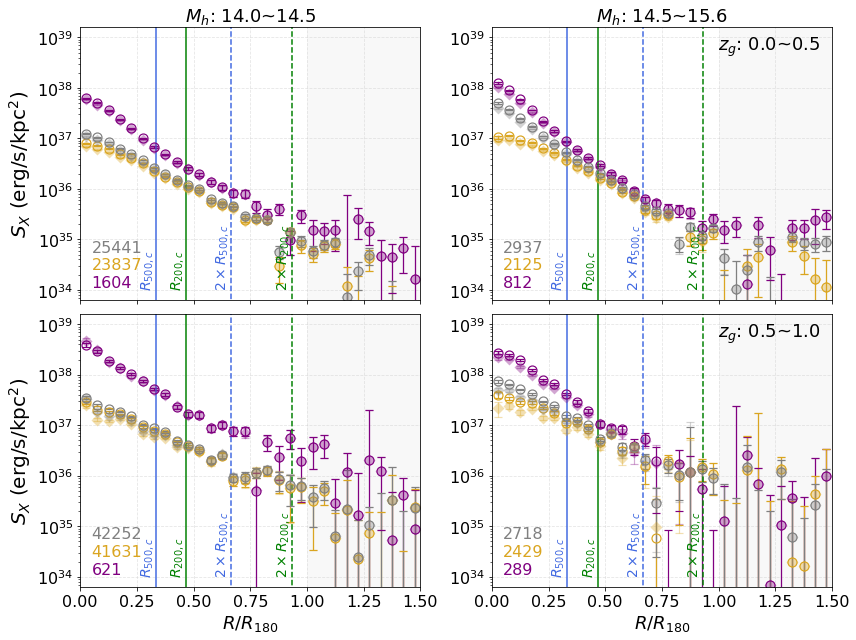

In [29]:
fig = plt.figure(figsize=(12,9))
cl_names = ['purple','goldenrod','grey']

for bk in range(2):
    for bj in range(len(mbins)-1):
        ax = fig.add_subplot(2,2,2*bk+bj+1)
        plt.grid(linestyle='dashed', color='#cccccc',zorder=2,alpha=0.5)
        ax.fill_between([1,2],[0,0],[1e50,1e50],fc='gainsboro',ec='none',alpha=0.2)
        plt.xlim(0.0, 1.5)
        plt.yscale('log')
        ymx = 39.2
        ymn = ymx-5.4
#         ax.yaxis.set_major_locator(ticker.LogLocator(base=10, numticks=15))
        plt.ylim(10**ymn,10**ymx)
        
        for i in range(dn):
            num_ = NN_bins[i,bk,bj]
            if num_ < 100:
                continue
            xval = 0.5*(rrs[i,bk,bj][:-1]+rrs[i,bk,bj][1:])
            yval1 = flbin[i,bk,bj][:-1]
            yerr1 = np.sqrt(snbin[i,bk,bj][:-1]**2+jkbin[i,bk,bj][:-1]**2)
            yval = flbin_nosqb[i,bk,bj][:-1]
            yerr = np.sqrt(snbin_nosqb[i,bk,bj][:-1]**2+jkbin_nosqb[i,bk,bj][:-1]**2)

            err_plot(xval, yval, yerr, 'none', cl_names[i], cl_names[i], '', 0.35, 'D',9)
            err_plot(xval, yval1, yerr1, cl_names[i], 'none', cl_names[i], '', 1.,'o',9)
            
            ax.text(0.05,0.7*10**(ymn+0.35+0.35*i),str(int(NN_bins[i,bk,bj])),
                    ha='left',va='bottom',size=16, color=cl_names[i])

        ax.plot([1/3,1/3],[0,1e50],'-',color='royalblue')
        ax.text(1/3,1e34,r'$R_{500,c}$',va='bottom',ha='right',rotation=90,size=14,color='royalblue')
        ax.plot([1.4/3,1.4/3],[0,1e50],'-',color='green')
        ax.text(1.4/3,1e34,r'$R_{200,c}$',va='bottom',ha='right',rotation=90,size=14,color='green')
        ax.plot([2/3,2/3],[0,1e50],'--',color='royalblue')
        ax.text(2/3,1e34,r'$2 \times R_{500,c}$',va='bottom',ha='right',rotation=90,size=14,color='royalblue')
        ax.plot([2.8/3,2.8/3],[0,1e50],'--',color='green')
        ax.text(2.8/3,1e34,r'$2 \times R_{200,c}$',va='bottom',ha='right',rotation=90,size=14,color='green')
        
        if bk == 0:
            ax.set_title(r'$M_h$: '+str(np.round(mbins[bj],2))+'~'+str(np.round(mbins[bj+1],2)),size=18)
            ax.set_xticklabels([])
        else:
            ax.set_xlabel(r'$R/R_{180}$',fontsize=18)
        if bj == 1:
            ax.text(1.45,0.7*10**ymx,r'$z_g$: '+str(np.round(0.5*bk,2))+'~'+str(np.round(0.5*(bk+1),2)),ha='right',va='top',size=18)
        else:
            ax.set_ylabel(r'$S_X$ (erg/s/kpc$^2$)',fontsize=20)    
        plt.tick_params(axis='both', which='major', labelsize=16)

plt.tight_layout()